# Consumer Finances in the USA Analysis

**Author:** Your Name  
**Date:** 2025-11-12  

## Project Overview
This notebook analyzes the 2019 Survey of Consumer Finances (SCF) dataset to explore patterns among small business owners in the USA.  
Key steps include:

- Data generation/loading and cleaning
- Exploratory data analysis (EDA)
- Feature variance analysis
- Clustering using K-Means
- Dimensionality reduction with PCA
- Visualizations for insights


In [24]:
# -------------------------
# Imports
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats.mstats import trimmed_var
import plotly.express as px

In [8]:
# -------------------------
# Setup directories
# -------------------------
os.makedirs("data/raw", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [9]:
# -------------------------
# Generate raw data
# -------------------------
np.random.seed(42)
n_rows = 500

mock_data = pd.DataFrame({
    "HBUS": np.random.choice([0, 1], size=n_rows, p=[0.8, 0.2]),  # business owner
    "INCCAT": np.random.randint(1, 7, size=n_rows),  # income category
    "INCOME": np.random.randint(20_000, 600_000, size=n_rows),
    "DEBT": np.random.randint(0, 2_000_000, size=n_rows),
    "HOUSES": np.random.randint(0, 5_000_000, size=n_rows),
    "AGE": np.random.randint(18, 80, size=n_rows),
    "FEATURE1": np.random.randn(n_rows),
    "FEATURE2": np.random.randn(n_rows),
    "FEATURE3": np.random.randn(n_rows),
    "FEATURE4": np.random.randn(n_rows),
    "FEATURE5": np.random.randn(n_rows),
})

raw_file_path = "data/raw/consumer_finances.csv"
mock_data.to_csv(raw_file_path, index=False)
print(f"✅ Mock data saved to {raw_file_path}")

✅ Mock data saved to data/raw/consumer_finances.csv


In [10]:
# -------------------------
# Load data
# -------------------------
df = pd.read_csv(raw_file_path)
print("df shape:", df.shape)
display(df.head())


df shape: (500, 11)


,HBUS,INCCAT,INCOME,DEBT,HOUSES,AGE,FEATURE1,FEATURE2,FEATURE3,FEATURE4,FEATURE5
0,0,6,552954,100734,1012384,43,-0.927353,1.617213,-2.529560,-0.172802,-0.995148
1,1,1,318512,157702,866964,21,0.238369,0.104356,-0.296607,0.771920,-0.181503
2,0,1,586202,754122,49104,79,0.975198,-0.898784,0.241322,0.441307,-2.177065
3,0,1,221579,1225811,3056277,56,0.501094,-1.330314,-1.151014,-0.733156,0.178477
4,0,5,524471,1147087,863663,56,0.189582,-0.189120,0.386323,0.228996,1.428858


In [11]:
# -------------------------
# 1. Percentage of business owners
# -------------------------
pct_biz_owners = df["HBUS"].mean() * 100
print(f"% of business owners in df: {pct_biz_owners:.2f}%")


% of business owners in df: 21.20%


In [12]:
# -------------------------
# 2. Income category frequencies by business owner
# -------------------------
inccat_dict = {1:"0-20", 2:"21-39.9", 3:"40-59.9", 4:"60-79.9", 5:"80-89.9", 6:"90-100"}

df_inccat = (
    df["INCCAT"]
    .replace(inccat_dict)
    .groupby(df["HBUS"])
    .value_counts(normalize=True)
    .rename("frequency")
    .to_frame()
    .reset_index()
)

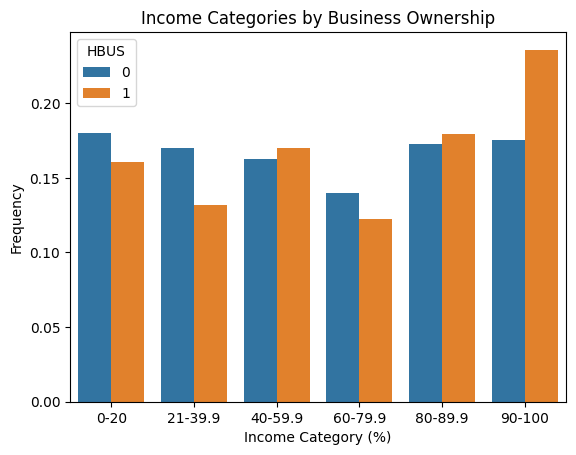

In [13]:
# -------------------------
# 3. Side-by-side bar chart
# -------------------------
sns.barplot(
    x="INCCAT",
    y="frequency",
    hue="HBUS",
    data=df_inccat,
    order=inccat_dict.values()
)
plt.xlabel("Income Category (%)")
plt.ylabel("Frequency")
plt.title("Income Categories by Business Ownership")
plt.show()

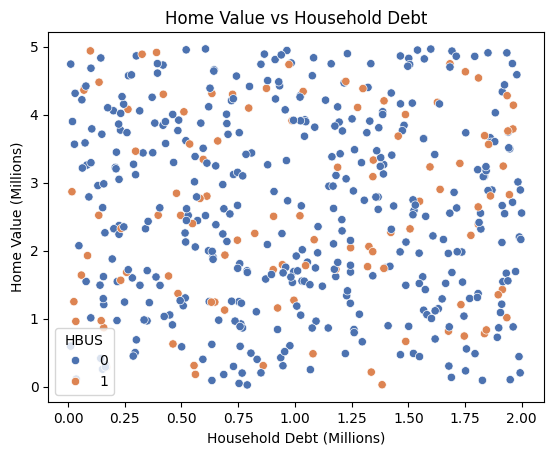

In [14]:
# -------------------------
# 4. Scatter plot: HOUSES vs DEBT
# -------------------------
sns.scatterplot(x=df["DEBT"]/1e6, y=df["HOUSES"]/1e6, hue=df["HBUS"], palette="deep")
plt.xlabel("Household Debt (Millions)")
plt.ylabel("Home Value (Millions)")
plt.title("Home Value vs Household Debt")
plt.show()

In [15]:
# -------------------------
# 5. Filter business owners with income < $500k
# -------------------------
df_small_biz = df[(df["HBUS"]==1) & (df["INCOME"] < 500_000)]
display(df_small_biz.head())


,HBUS,INCCAT,INCOME,DEBT,HOUSES,AGE,FEATURE1,FEATURE2,FEATURE3,FEATURE4,FEATURE5
1,1,1,318512,157702,866964,21,0.238369,0.104356,-0.296607,0.771920,-0.181503
7,1,4,403152,1731897,1206861,18,0.677875,1.511155,1.573020,0.298158,0.329107
11,1,3,178768,98818,4936600,23,1.373659,0.363632,-0.451659,0.148089,-1.968923
12,1,5,266726,973950,4736319,58,-0.137449,0.886887,0.195025,-0.881068,0.103438
35,1,3,320709,70326,4359879,45,-0.692421,0.462591,0.479442,0.554058,-0.086070


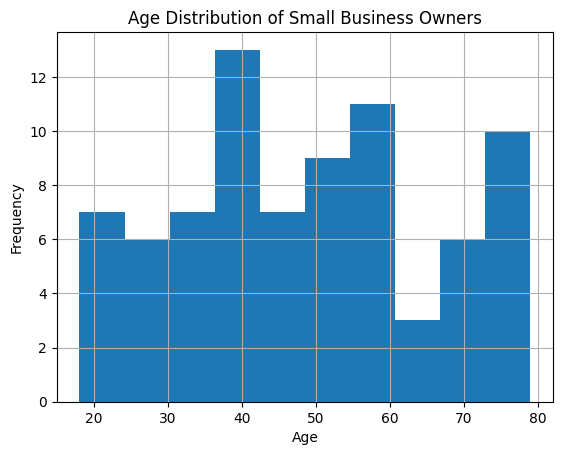

In [16]:
# -------------------------
# 6. Histogram of AGE
# -------------------------
df_small_biz["AGE"].hist(bins=10)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution of Small Business Owners")
plt.show()


In [17]:
# -------------------------
# 7. Variance of features
# -------------------------
top_ten_var = df_small_biz.var().sort_values().tail(10)
print("Top 10 features by variance:")
display(top_ten_var)

Top 10 features by variance:


FEATURE5    7.223095e-01
FEATURE2    8.861077e-01
FEATURE1    9.327266e-01
FEATURE4    1.139537e+00
FEATURE3    1.305529e+00
INCCAT      3.311587e+00
AGE         3.071503e+02
INCOME      1.706338e+10
DEBT        3.858994e+11
HOUSES      1.898524e+12
dtype: float64

In [18]:
# -------------------------
# 8. Trimmed variance (exclude top/bottom 10% of values)
# -------------------------
top_ten_trim_var = df_small_biz.apply(trimmed_var, limits=(0.1,0.1)).sort_values().tail(10)
print("Top 10 features by trimmed variance:")
display(top_ten_trim_var)


Top 10 features by trimmed variance:


FEATURE5    2.733652e-01
FEATURE1    3.310783e-01
FEATURE2    4.090355e-01
FEATURE4    5.460822e-01
FEATURE3    5.754009e-01
INCCAT      2.616331e+00
AGE         1.937822e+02
INCOME      1.069666e+10
DEBT        2.801410e+11
HOUSES      1.210962e+12
dtype: float64

In [19]:
# -------------------------
# 9. Horizontal bar chart of top trimmed variance
# -------------------------
fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    orientation='h',
    title="Top 10 Trimmed Variance Features"
)
fig.show()

In [20]:
# -------------------------
# 10. High variance columns
# -------------------------
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
X = df_small_biz[high_var_cols]


In [21]:
# -------------------------
# 11-12. K-Means clustering, test 2-12 clusters
# -------------------------
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

for k in n_clusters:
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    model.fit(X)
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    silhouette_scores.append(
        silhouette_score(X, model.named_steps["kmeans"].labels_)
    )

# Plot inertia and silhouette
fig = px.line(x=n_clusters, y=inertia_errors, title="Inertia vs Number of Clusters")
fig.show()

fig = px.line(x=n_clusters, y=silhouette_scores, title="Silhouette Score vs Number of Clusters")
fig.show()


In [22]:
# -------------------------
# 13-15. Final K-Means with 3 clusters
# -------------------------
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=42))
final_model.fit(X)
labels = final_model.named_steps["kmeans"].labels_

# Mean values by cluster
xgb = X.groupby(labels).mean()
fig = px.bar(xgb, barmode="group", title="Mean Feature Values by Cluster")
fig.show()


In [23]:
# -------------------------
# 16-17. PCA to 2D
# -------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=["PC1","PC2"])
fig = px.scatter(
    X_pca, x="PC1", y="PC2", color=labels.astype(str),
    title="PCA Representation of Clusters"
)
fig.show()


## Conclusion

- The dataset provides insights into income, household debt, home values, and demographics of small business owners.  
- Feature variance analysis helped identify the most informative variables.  
- K-Means clustering revealed natural groupings among business owners based on key financial features.  
- PCA visualization confirms the separation of clusters in reduced 2D space.  

